In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
import io
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
# sklearn models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# sklearn tools
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Statistical packages
import statsmodels.api as sm
from statsmodels.formula.api import ols   # ordinary least squares model
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [103]:

df = pd.read_csv('/content/drive/MyDrive/THESIS_MACHINE_LEARNING/Revised_Data.csv')
df

,Cpds,LogKow,Electron C2,Electron N,Molecular Weight
0,DPA2,3.50,0.324,-0.702,169
1,DM-AD2,4.14,0.270,-0.676,209
2,IPDM-AD2,5.59,0.269,-0.677,251
3,DIP-DPA2,6.20,0.323,-0.706,253
4,DIPDM-AD2,7.05,0.264,-0.678,293
5,DPPD2,3.30,0.217,-0.705,260
6,PTPD2,3.90,0.288,-0.671,274
7,DTPD2,4.60,0.285,-0.671,288
8,TO-DPA2,7.05,0.327,-0.707,281
9,TOS-DPA2,9.21,0.330,-0.710,385


In [104]:
# Assuming X contains your features and df contains your data
# Define X as the features
X = df.iloc[:, 2:]  # Assuming your features start from the third column, adjust accordingly if needed
print("X (Features):\n", X)

# Filter out the rows corresponding to IP-DPA, S-DPA, and DTO-DPA for the test data
test_indices = [11, 12, 13]
test = df.loc[test_indices]
print("\nTest Data (Rows 11, 12, 13):\n", test)

train_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train = df.loc[train_indices]
print("\nTrain Data (Rows 0-10):\n", train)

# Select rows for train set
X_train = X.iloc[train_indices]
print("\nX_train (Features for Training):\n", X_train)

# Select rows for test set
X_test = X.iloc[test_indices]
print("\nX_test (Features for Test):\n", X_test)

# Extracting target and features for training data
y_train = train.iloc[:, 1]
X_train = train.iloc[:, 2:]  # Uncomment if you're using X_train
print("\ny_train (Target for Training):\n", y_train)
print("\nX_train (Features for Training):\n", X_train)

# Extracting target and features for test data
y_vset = test.iloc[:, 1]
X_vset = test.iloc[:, 2:]
print("\ny_vset (Target for Test):\n", y_vset)
print("\nX_vset (Features for Test):\n", X_vset)


X (Features):
     Electron C2  Electron N  Molecular Weight
0         0.324      -0.702               169
1         0.270      -0.676               209
2         0.269      -0.677               251
3         0.323      -0.706               253
4         0.264      -0.678               293
5         0.217      -0.705               260
6         0.288      -0.671               274
7         0.285      -0.671               288
8         0.327      -0.707               281
9         0.330      -0.710               385
10        0.325      -0.710               479
11        0.321      -0.704               211
12        0.326      -0.705               273
13        0.330      -0.711               293

Test Data (Rows 11, 12, 13):
         Cpds  LogKow  Electron C2  Electron N  Molecular Weight
11   IP-DPA2    4.75        0.321      -0.704               211
12    S-DPA2    5.45        0.326      -0.705               273
13  DTO-DPA2   10.33        0.330      -0.711               293

Train D

In [105]:
y_train = train.iloc[:,1]
X_train = train.iloc[:,2:]

y_test = test.iloc[:,1]
X_test = test.iloc[:,2:]

In [51]:
pip install optuna

In [102]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Define the objective function
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 2000)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    max_features = trial.suggest_int("max_features", 1, X_train.shape[1])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)

    # Define the penalty factor (you can adjust this value)
    penalty_factor = 0.3  # Example: lower values reduce the penalty

    # Create a GBR model with suggested hyperparameters
    GBR = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        learning_rate=learning_rate,
        loss="squared_error"
    )

    # Fit the model
    model = GBR.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE for train and test
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

    # Apply the penalty
    penalty = penalty_factor * abs(rmse_train - rmse_test)

    # Minimize both test RMSE and the scaled penalty
    return rmse_test + penalty

# Create a study
study = optuna.create_study(direction="minimize")

# Optimize the study
study.optimize(objective, n_trials=50)

# Best hyperparameters
#print("Best hyperparameters:", study.best_params)


[I 2024-12-10 01:12:11,154] A new study created in memory with name: no-name-752583e9-8d06-43b3-8641-8f1c6df9c149
[I 2024-12-10 01:12:11,846] Trial 0 finished with value: 2.6375878726182505 and parameters: {'n_estimators': 730, 'max_depth': 3, 'max_features': 1, 'min_samples_split': 16, 'learning_rate': 0.04308231387341718}. Best is trial 0 with value: 2.6375878726182505.
[I 2024-12-10 01:12:11,965] Trial 1 finished with value: 2.6375878726182505 and parameters: {'n_estimators': 154, 'max_depth': 7, 'max_features': 18, 'min_samples_split': 13, 'learning_rate': 0.009156595942823809}. Best is trial 0 with value: 2.6375878726182505.
[I 2024-12-10 01:12:12,850] Trial 2 finished with value: 2.6375878726182505 and parameters: {'n_estimators': 1100, 'max_depth': 8, 'max_features': 19, 'min_samples_split': 12, 'learning_rate': 0.08352174512600609}. Best is trial 0 with value: 2.6375878726182505.
[I 2024-12-10 01:12:13,965] Trial 3 finished with value: 0.9675360804581662 and parameters: {'n_est

In [79]:
params = {
    "n_estimators": 1000,  # Increase the number of trees
    "max_depth": 6,  # Try a lower depth to prevent overfitting
    "max_features": 6,  # Experiment with reducing the number of features
    "min_samples_split": 10,  # Increase to encourage simpler trees

    "learning_rate": 0.005,  # Decrease the learning rate
    "loss": "squared_error",
}


In [83]:
GBR = GradientBoostingRegressor(**params)
model = GBR.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('Root Mean squared error (RMSE): %.3f'
      % mean_squared_error(y_train, y_pred_train, squared=False))
print('Coefficient of determination (R^2): %.3f'
      % r2_score(y_train, y_pred_train))
print('Root Mean squared error (RMSE): %.3f'
      % mean_squared_error(y_test, y_pred_test,squared=False))
print('Coefficient of determination (R^2): %.3f'
      % r2_score(y_test, y_pred_test))

Root Mean squared error (RMSE): 0.363
Coefficient of determination (R^2): 0.983
Root Mean squared error (RMSE): 0.641
Coefficient of determination (R^2): 0.933


In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np

# Convert X_train and y_train to NumPy arrays
X_train_np = X_train.values if hasattr(X_train, "values") else X_train
y_train_np = y_train.values if hasattr(y_train, "values") else y_train

# Initialize K-Fold Cross-Validation
n_splits = 5  # Specify the number of splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store R² scores for each fold
r2_scores = []

# Perform Cross-Validation
for train_index, test_index in kf.split(X_train_np):
    # Split the data into training and validation folds
    X_cv_train, X_cv_test = X_train_np[train_index], X_train_np[test_index]
    y_cv_train, y_cv_test = y_train_np[train_index], y_train_np[test_index]

    # Use the existing model to predict on the validation fold
    y_pred = model.predict(X_cv_test)

    # Calculate R² score for the validation fold
    r2_fold = r2_score(y_cv_test, y_pred)
    r2_scores.append(r2_fold)

# Calculate Mean and Standard Deviation of R² Scores
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Display Results
print(f"Mean R² (Cross-Validation): {mean_r2:.4f} ± {std_r2:.4f}")


Mean R² (Cross-Validation): 0.8044 ± 0.1694


In [84]:
# Print predicted data for train set
print("Predicted data for train set:")
print(y_pred_train)

# Print predicted data for test set
print("\nPredicted data for test set:")
print(y_pred_test)


Predicted data for train set:
[ 3.83002345  4.39583182  5.77648293  6.01550632  6.58537231  3.82232764
  4.07564505  4.64001383  7.0069044   9.22011594 12.14177631]

Predicted data for test set:
[4.69190009 5.94183943 9.33719515]


In [85]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming train and test datasets are already loaded as pandas DataFrames
y_train = train.iloc[:, 1]
X_train = train.iloc[:, 2:]

y_test = test.iloc[:, 1]
X_test = test.iloc[:, 2:]

# New set of compounds and their features
data = {
    "Structures": ["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10", "R2"],
    "Electron C2": [0.313, 0.308, 0.329, 0.33, 0.33, 0.32, 0.324, 0.314, 0.32, 0.321, 0.354],
    "Electron N": [-0.705, -0.704, -0.706, -0.717, -0.712, -0.712, -0.712, -0.705, -0.711, -0.712, -0.696],
    "Molecular Weight": [199, 212, 256, 284, 315, 347, 255, 229, 437, 257, 212]
}

new_compounds = pd.DataFrame(data)

# Ensure the new DataFrame has the same columns as the training data
X_new = pd.DataFrame(columns=X_train.columns)
for column in X_new.columns:
    if column in new_compounds.columns:
        X_new[column] = new_compounds[column]
    else:
        X_new[column] = 0  # Fill missing columns with 0

# Fill any remaining NaN values with 0
X_new = X_new.fillna(0)

# Predicting the LogKow for the new compounds
y_pred_new = model.predict(X_new)

# Adding the predictions to the new_compounds DataFrame
new_compounds["Predicted LogKow"] = y_pred_new

print(new_compounds)


   Structures  Electron C2  Electron N  Molecular Weight  Predicted LogKow
0          D1        0.313      -0.705               199          5.210766
1          D2        0.308      -0.704               212          5.210766
2          D3        0.329      -0.706               256          7.396731
3          D4        0.330      -0.717               284          8.466951
4          D5        0.330      -0.712               315          9.753219
5          D6        0.320      -0.712               347          8.852444
6          D7        0.324      -0.712               255          7.125727
7          D8        0.314      -0.705               229          5.210766
8          D9        0.320      -0.711               437          9.838673
9         D10        0.321      -0.712               257          7.125727
10         R2        0.354      -0.696               212          6.488606


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming params and GBR are already defined
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(GBR.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

# Print the boosting iterations, training set scores, and test set scores
print("Boosting Iterations, Training Set Score, Test Set Score")
for i in range(params["n_estimators"]):
    print(f"{i+1}, {GBR.train_score_[i]}, {test_score[i]}")


Boosting Iterations, Training Set Score, Test Set Score
1, 7.6238460932231416, 6.582006096406488
2, 7.5700147298068785, 6.589717948889068
3, 7.548388165457205, 6.594637037361507
4, 7.526161056330882, 6.5737243544766955
5, 7.504779358767182, 6.578606950575669
6, 7.451961826773054, 6.586329030080587
7, 7.399671149660565, 6.5940708919039075
8, 7.378116549580942, 6.573492621850387
9, 7.32655557617779, 6.5811882892556595
10, 7.305801554622899, 6.58610050670755
11, 7.259836278387325, 6.538934672387999
12, 7.239363141113617, 6.551969209795537
13, 7.193929766322201, 6.505663670213598
14, 7.143874163162565, 6.432967404031949
15, 7.099258515589466, 6.387743477133239
16, 7.079124046184296, 6.367971108903578
17, 7.030125124944444, 6.296819503899568
18, 7.0102728086723225, 6.309836679689453
19, 6.9618832599936775, 6.23943785026515
20, 6.9139763970631, 6.169787786884565
21, 6.866547405090255, 6.100878787917811
22, 6.824093096483819, 6.0582258648725436
23, 6.805181300891089, 6.039619339408844
24, 6.7

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming params and GBR are already defined
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(GBR.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

# Create a DataFrame with the boosting iterations, training set scores, and test set scores
output_df = pd.DataFrame({
    "Boosting Iterations": np.arange(1, params["n_estimators"] + 1),
    "Training Set Score": GBR.train_score_,
    "Test Set Score": test_score
})

# Specify the path to save the CSV file
output_path = '/content/drive/MyDrive/THESIS_MACHINE_LEARNING/boosting_iterations_scores.csv'

# Save the DataFrame to the specified CSV file
output_df.to_csv(output_path, index=False)

print(f"CSV file saved as '{output_path}'")


CSV file saved as '/content/drive/MyDrive/THESIS_MACHINE_LEARNING/boosting_iterations_scores.csv'


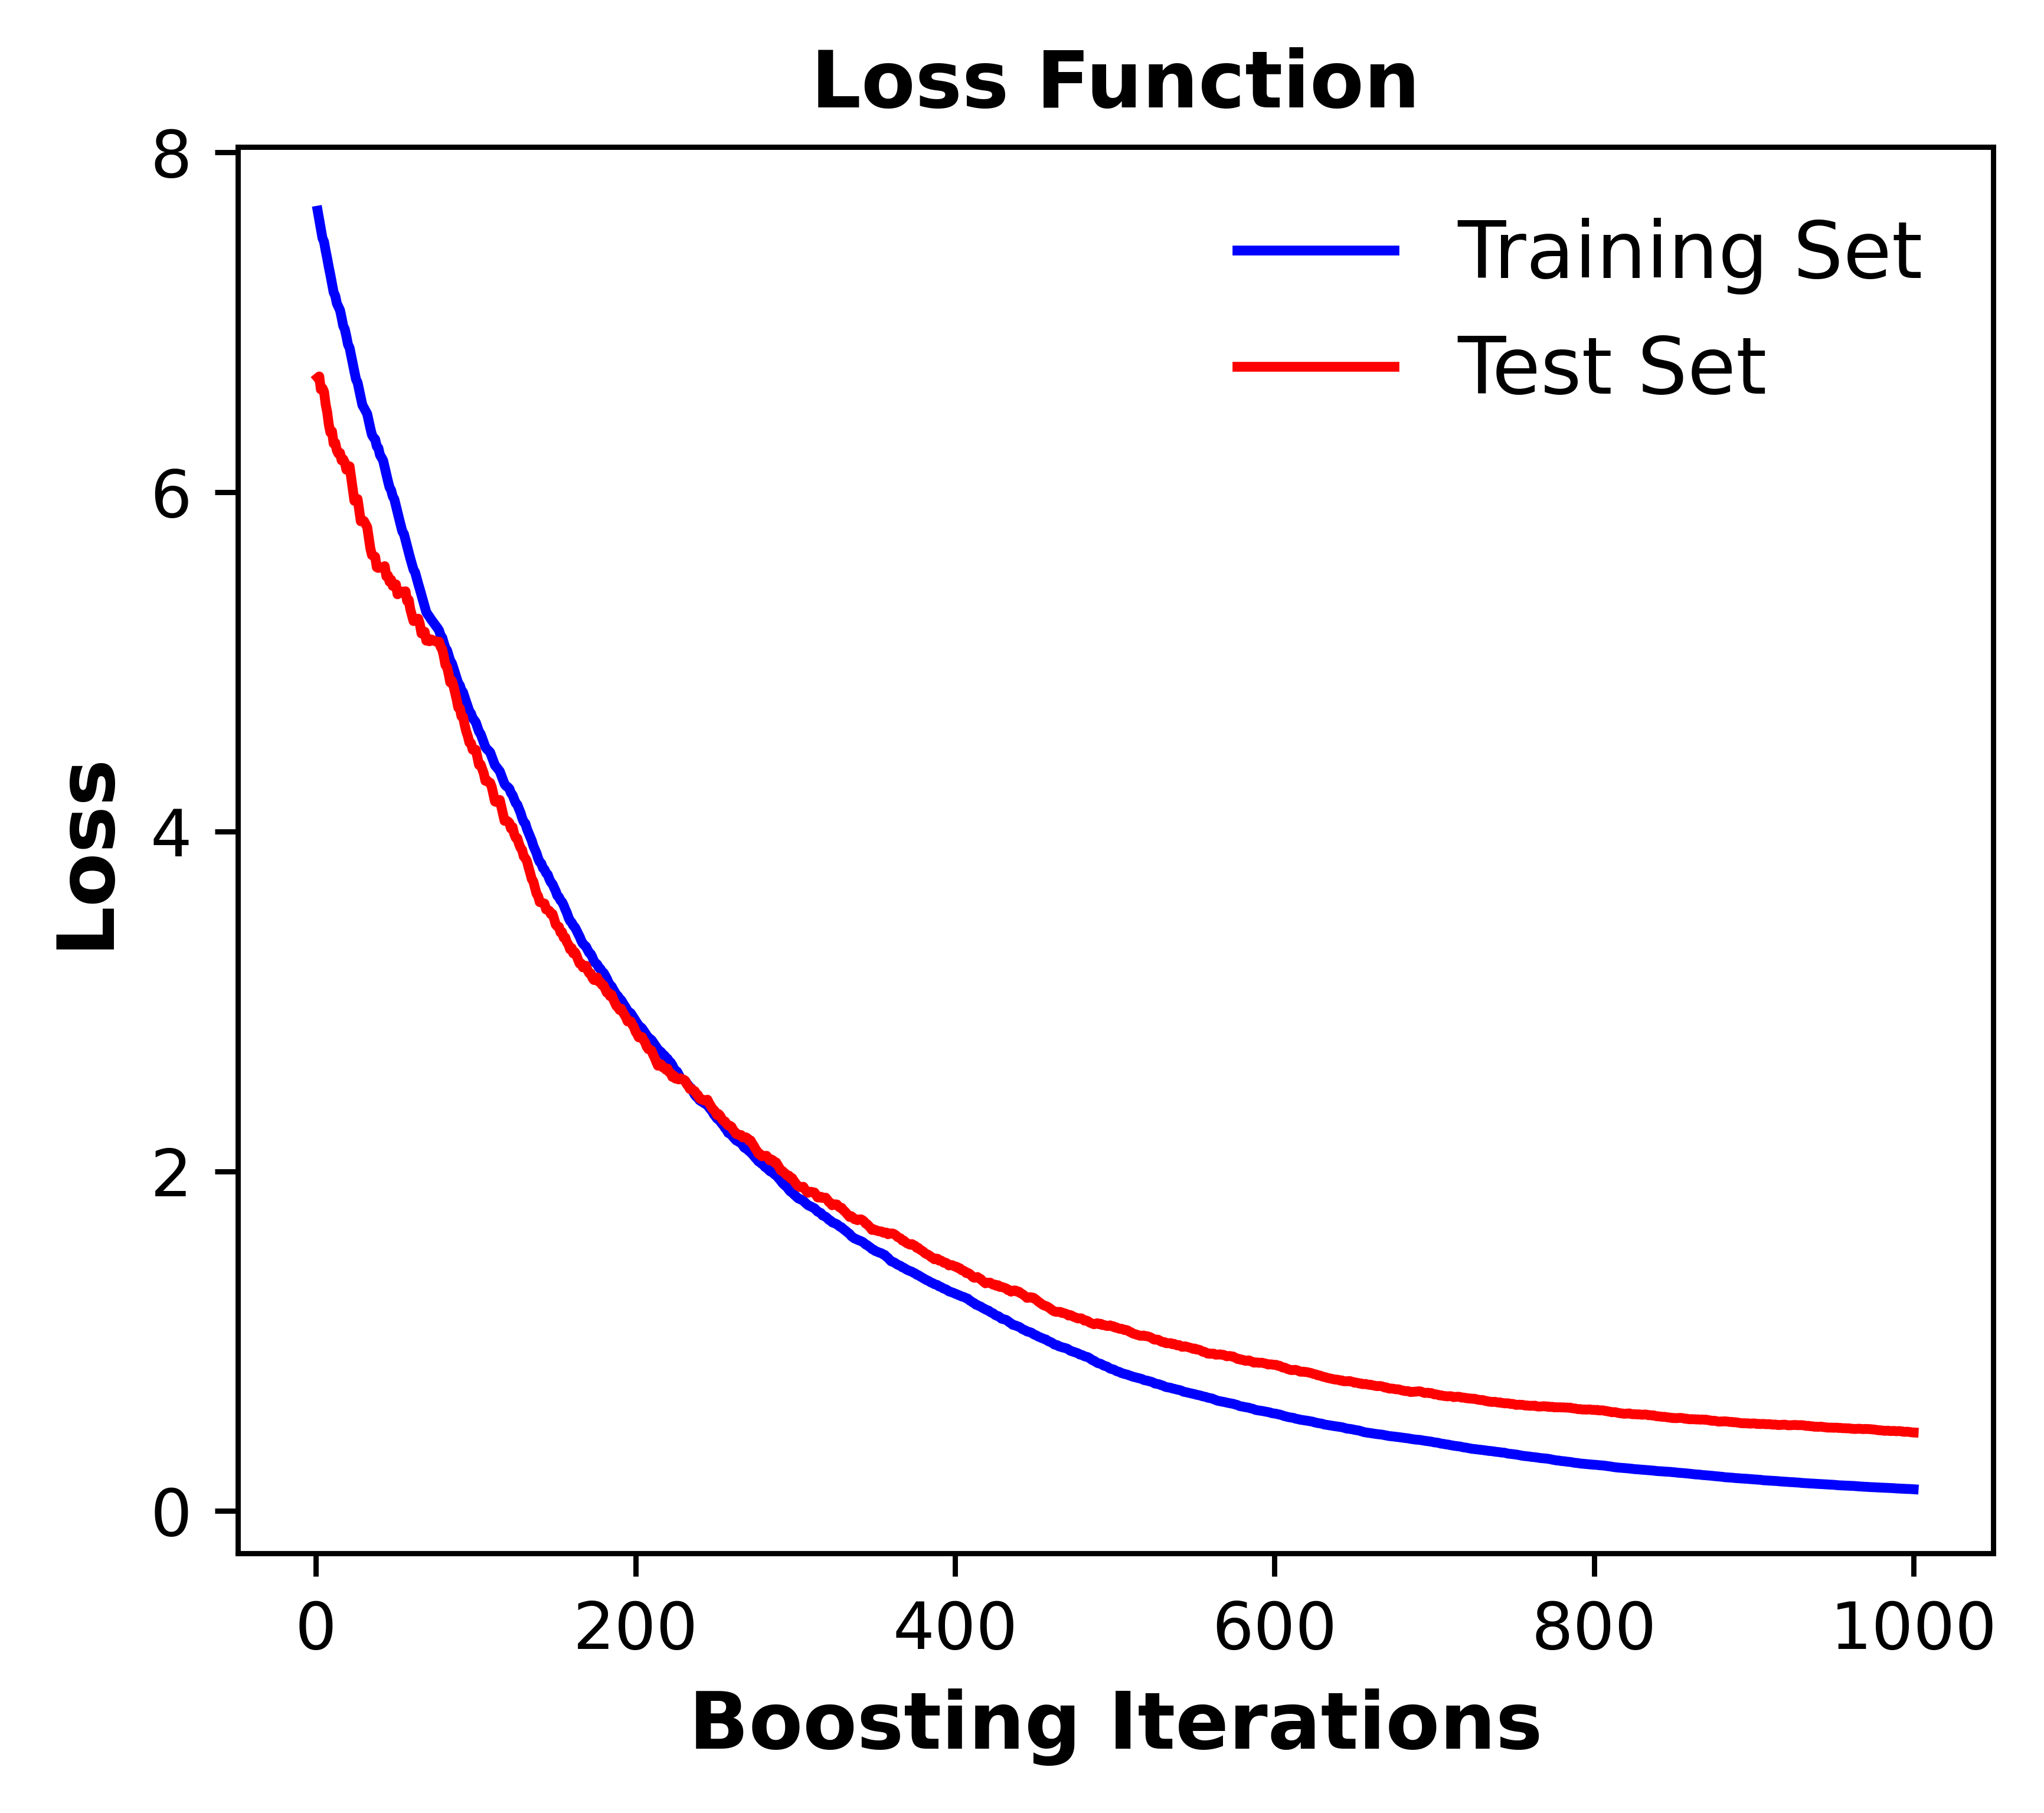

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming params and GBR are already defined
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(GBR.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

# Set font properties globally for labels
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12  # Use a numeric value for font size
})

# Create the figure with higher DPI for better resolution
fig = plt.figure(figsize=(4.5, 4), dpi=800)
plt.subplot(1, 1, 1)
plt.title("Loss Function", fontweight='bold', fontsize=12)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    GBR.train_score_,
    "b-",
    label="Training Set"
)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    test_score,
    "r-",
    label="Test Set"
)
plt.legend(loc="upper right", fontsize=12, frameon=False)  # Remove frame around legend
plt.xlabel("Boosting Iterations", fontweight='bold', fontsize=12)
plt.ylabel("Loss", fontweight='bold', fontsize=12)

# Set font properties for tick labels (non-bold)
plt.xticks(fontweight='normal', fontsize=10)
plt.yticks(fontweight='normal', fontsize=10)

fig.tight_layout()
plt.show()


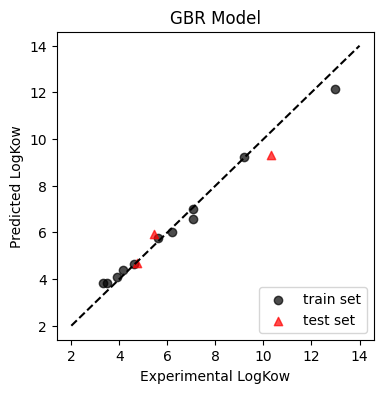

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Data visualization
plt.figure(figsize=(9, 4))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)

plt.scatter(x=y_train, y=y_pred_train, c="black", alpha=0.7)
plt.scatter(x=y_test, y=y_pred_test, c="r", marker='^', alpha=0.7)

plt.legend(("train set", "test set"), loc="lower right")
plt.plot([2, 14], [2, 14], "--", color="black")

x_ticks = np.arange(2, 16, 2)
y_ticks = np.arange(2, 16, 2)

plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.title('GBR Model')
plt.ylabel('Predicted LogKow')
plt.xlabel('Experimental LogKow')

plt.show()


In [87]:
!pip install shap

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Summary plot of combined SHAP values with feature names
shap.summary_plot(shap_values_combined, X_combined_df, show=False)
plt.title("SHAP Summary Plot for GBR Model - Combined Training and Test Data")
plt.show()

In [ ]:
import shap
import pandas as pd
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Print SHAP values and corresponding feature values for top 3 features
for i, feature in enumerate(top_3_features):
    print(f"\nFeature: {feature}")
    print("SHAP Value, Feature Value")
    for shap_val, feature_val in zip(shap_values_combined[:, top_3_indices[i]], X_combined_df[feature]):
        print(f"{shap_val}, {feature_val}")



Feature: Electron C2
SHAP Value, Feature Value
-0.3426419301381843, 0.324
-0.3426419301381843, 0.27
-0.3426419301381843, 0.269
-0.3426419301381843, 0.323
-0.30861432737120514, 0.264
-0.34177767261016095, 0.317
-0.3426419301381843, 0.288
-0.3426419301381843, 0.285
0.9064276863990183, 0.327
0.9064276863990183, 0.33
0.8933882080124352, 0.325
-0.3426419301381843, 0.321
0.9064276863990183, 0.326
0.9064276863990183, 0.33

Feature: Electron N
SHAP Value, Feature Value
-0.5036587686362591, -0.702
-0.5043046870268881, -0.676
-0.5043046870268881, -0.677
0.34889403834346344, -0.706
-0.5043046870268881, -0.678
-0.5036986333910715, -0.705
-0.5043046870268881, -0.671
-0.5043046870268881, -0.671
0.34889403834346344, -0.707
1.4169778027571738, -0.71
1.4141149577176706, -0.71
-0.5043046870268881, -0.704
-0.5043046870268881, -0.705
1.4169778027571738, -0.711

Feature: Molecular Weight
SHAP Value, Feature Value
-0.5343776350332932, 169
-0.5343776350332932, 209
-0.531854254447601, 251
-0.5314452765001492

In [ ]:
import shap
import pandas as pd
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Create a DataFrame to store SHAP values and feature values for top 3 features
output_df = pd.DataFrame()

for i, feature in enumerate(top_3_features):
    output_df[f"{feature}_SHAP"] = shap_values_combined[:, top_3_indices[i]]
    output_df[f"{feature}_Value"] = X_combined_df[feature].values

# Specify the path to save the CSV file
output_path = '/content/drive/MyDrive/THESIS_MACHINE_LEARNING/shap_values_top3_features.csv'

# Save the DataFrame to the specified CSV file
output_df.to_csv(output_path, index=False)

print(f"CSV file saved as '{output_path}'")


CSV file saved as '/content/drive/MyDrive/THESIS_MACHINE_LEARNING/shap_values_top3_features.csv'


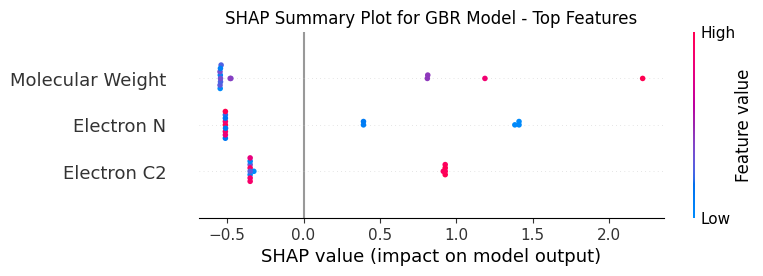

In [88]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Filter SHAP values and data for top features
shap_values_combined_top3 = shap_values_combined[:, top_3_indices]
X_combined_df_top3 = X_combined_df.iloc[:, top_3_indices]

# Summary plot of combined SHAP values with feature names for top 3 features
shap.summary_plot(shap_values_combined_top3, X_combined_df_top3, show=False)
plt.title("SHAP Summary Plot for GBR Model - Top Features")
plt.show()



<Figure size 6400x6400 with 0 Axes>

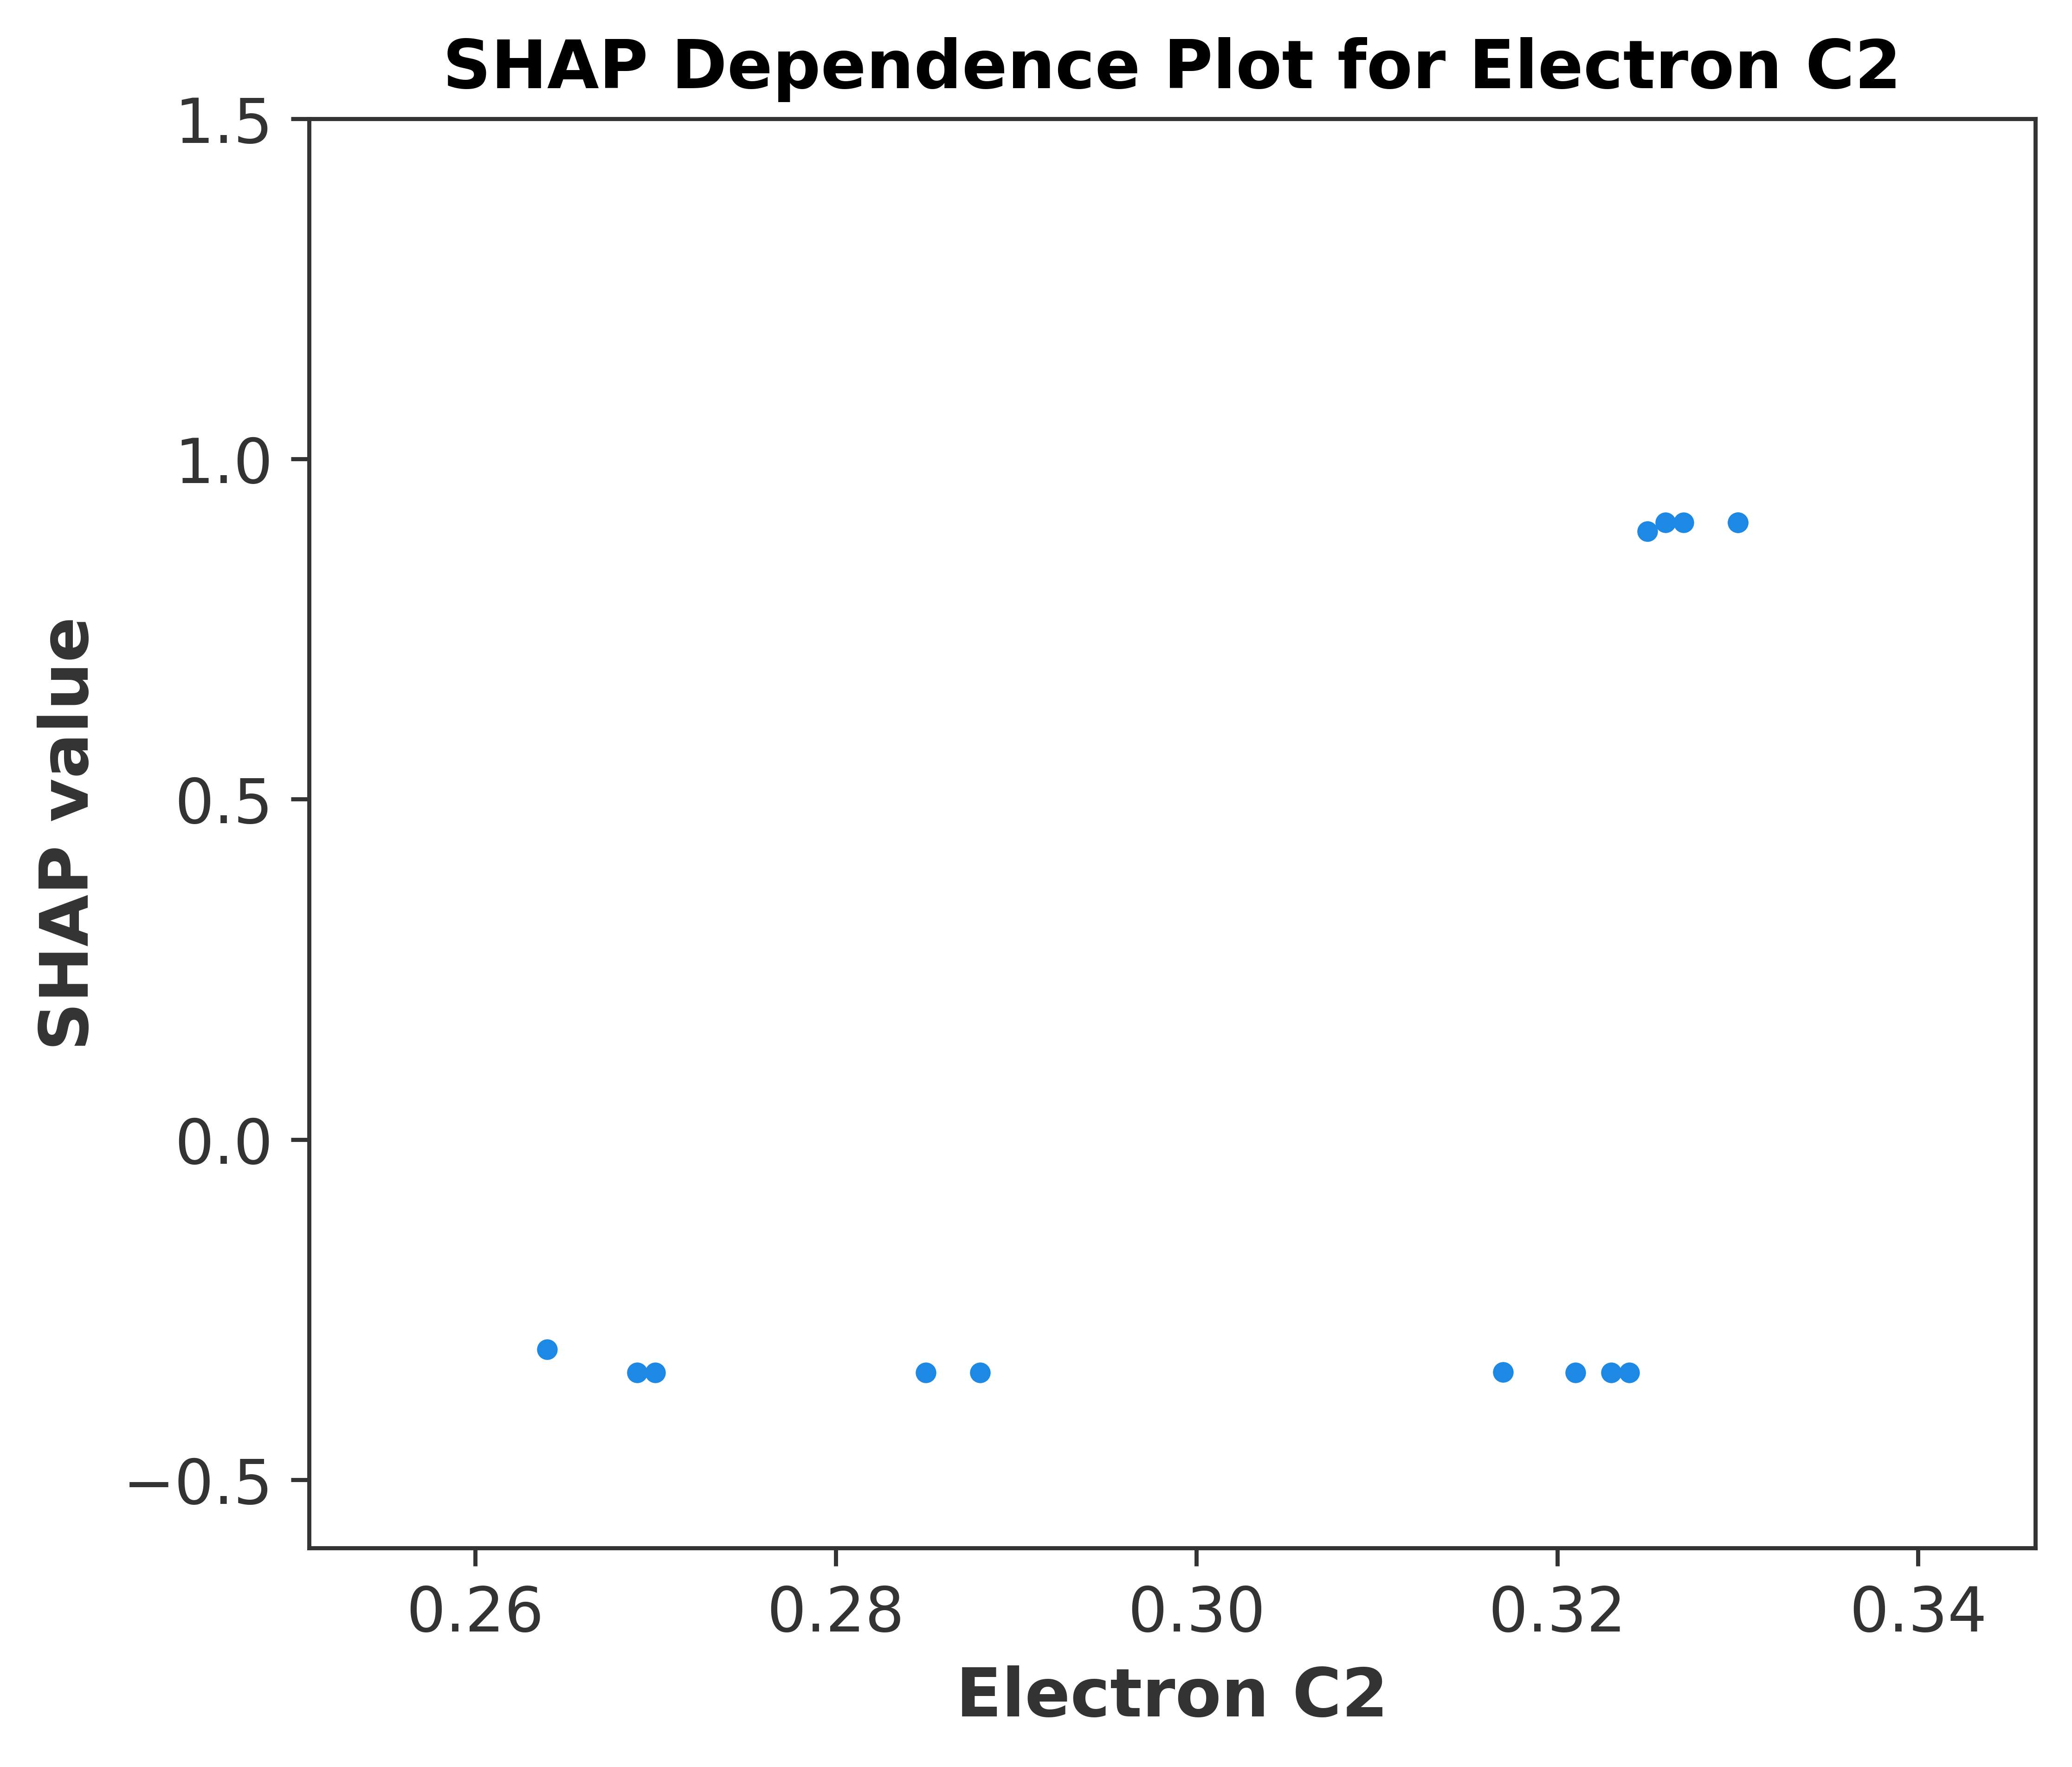

<Figure size 6400x6400 with 0 Axes>

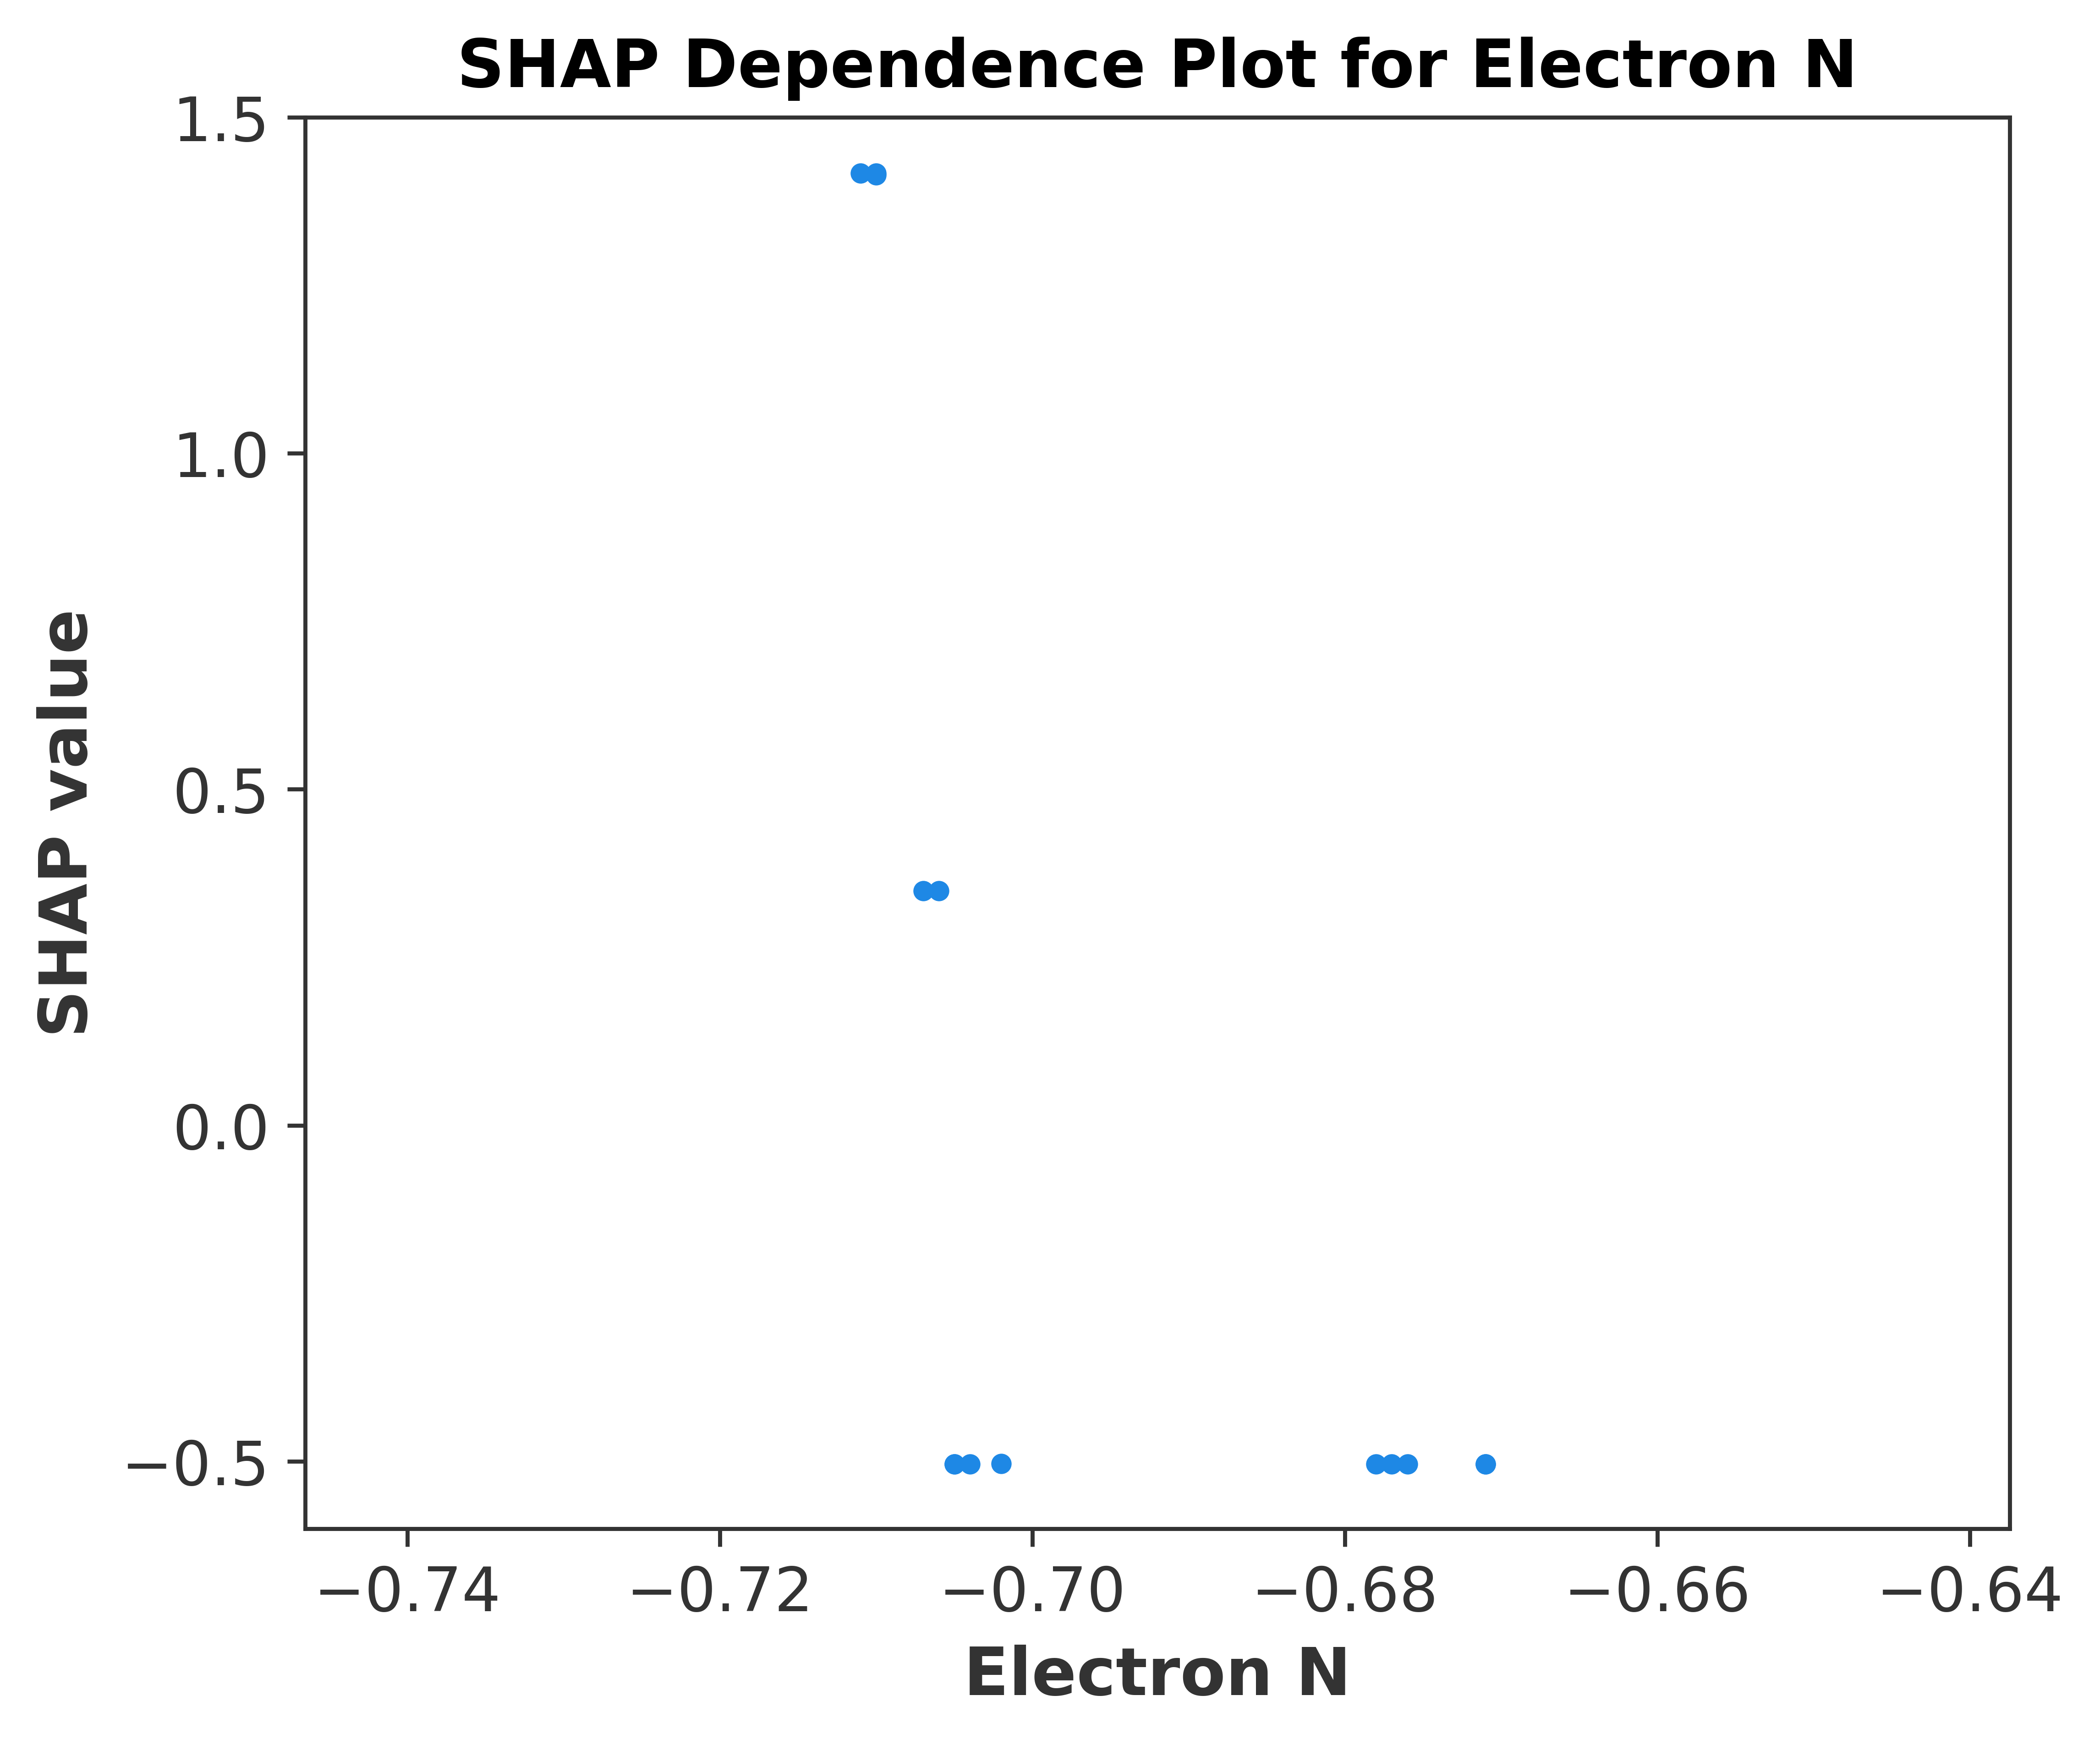

<Figure size 6400x6400 with 0 Axes>

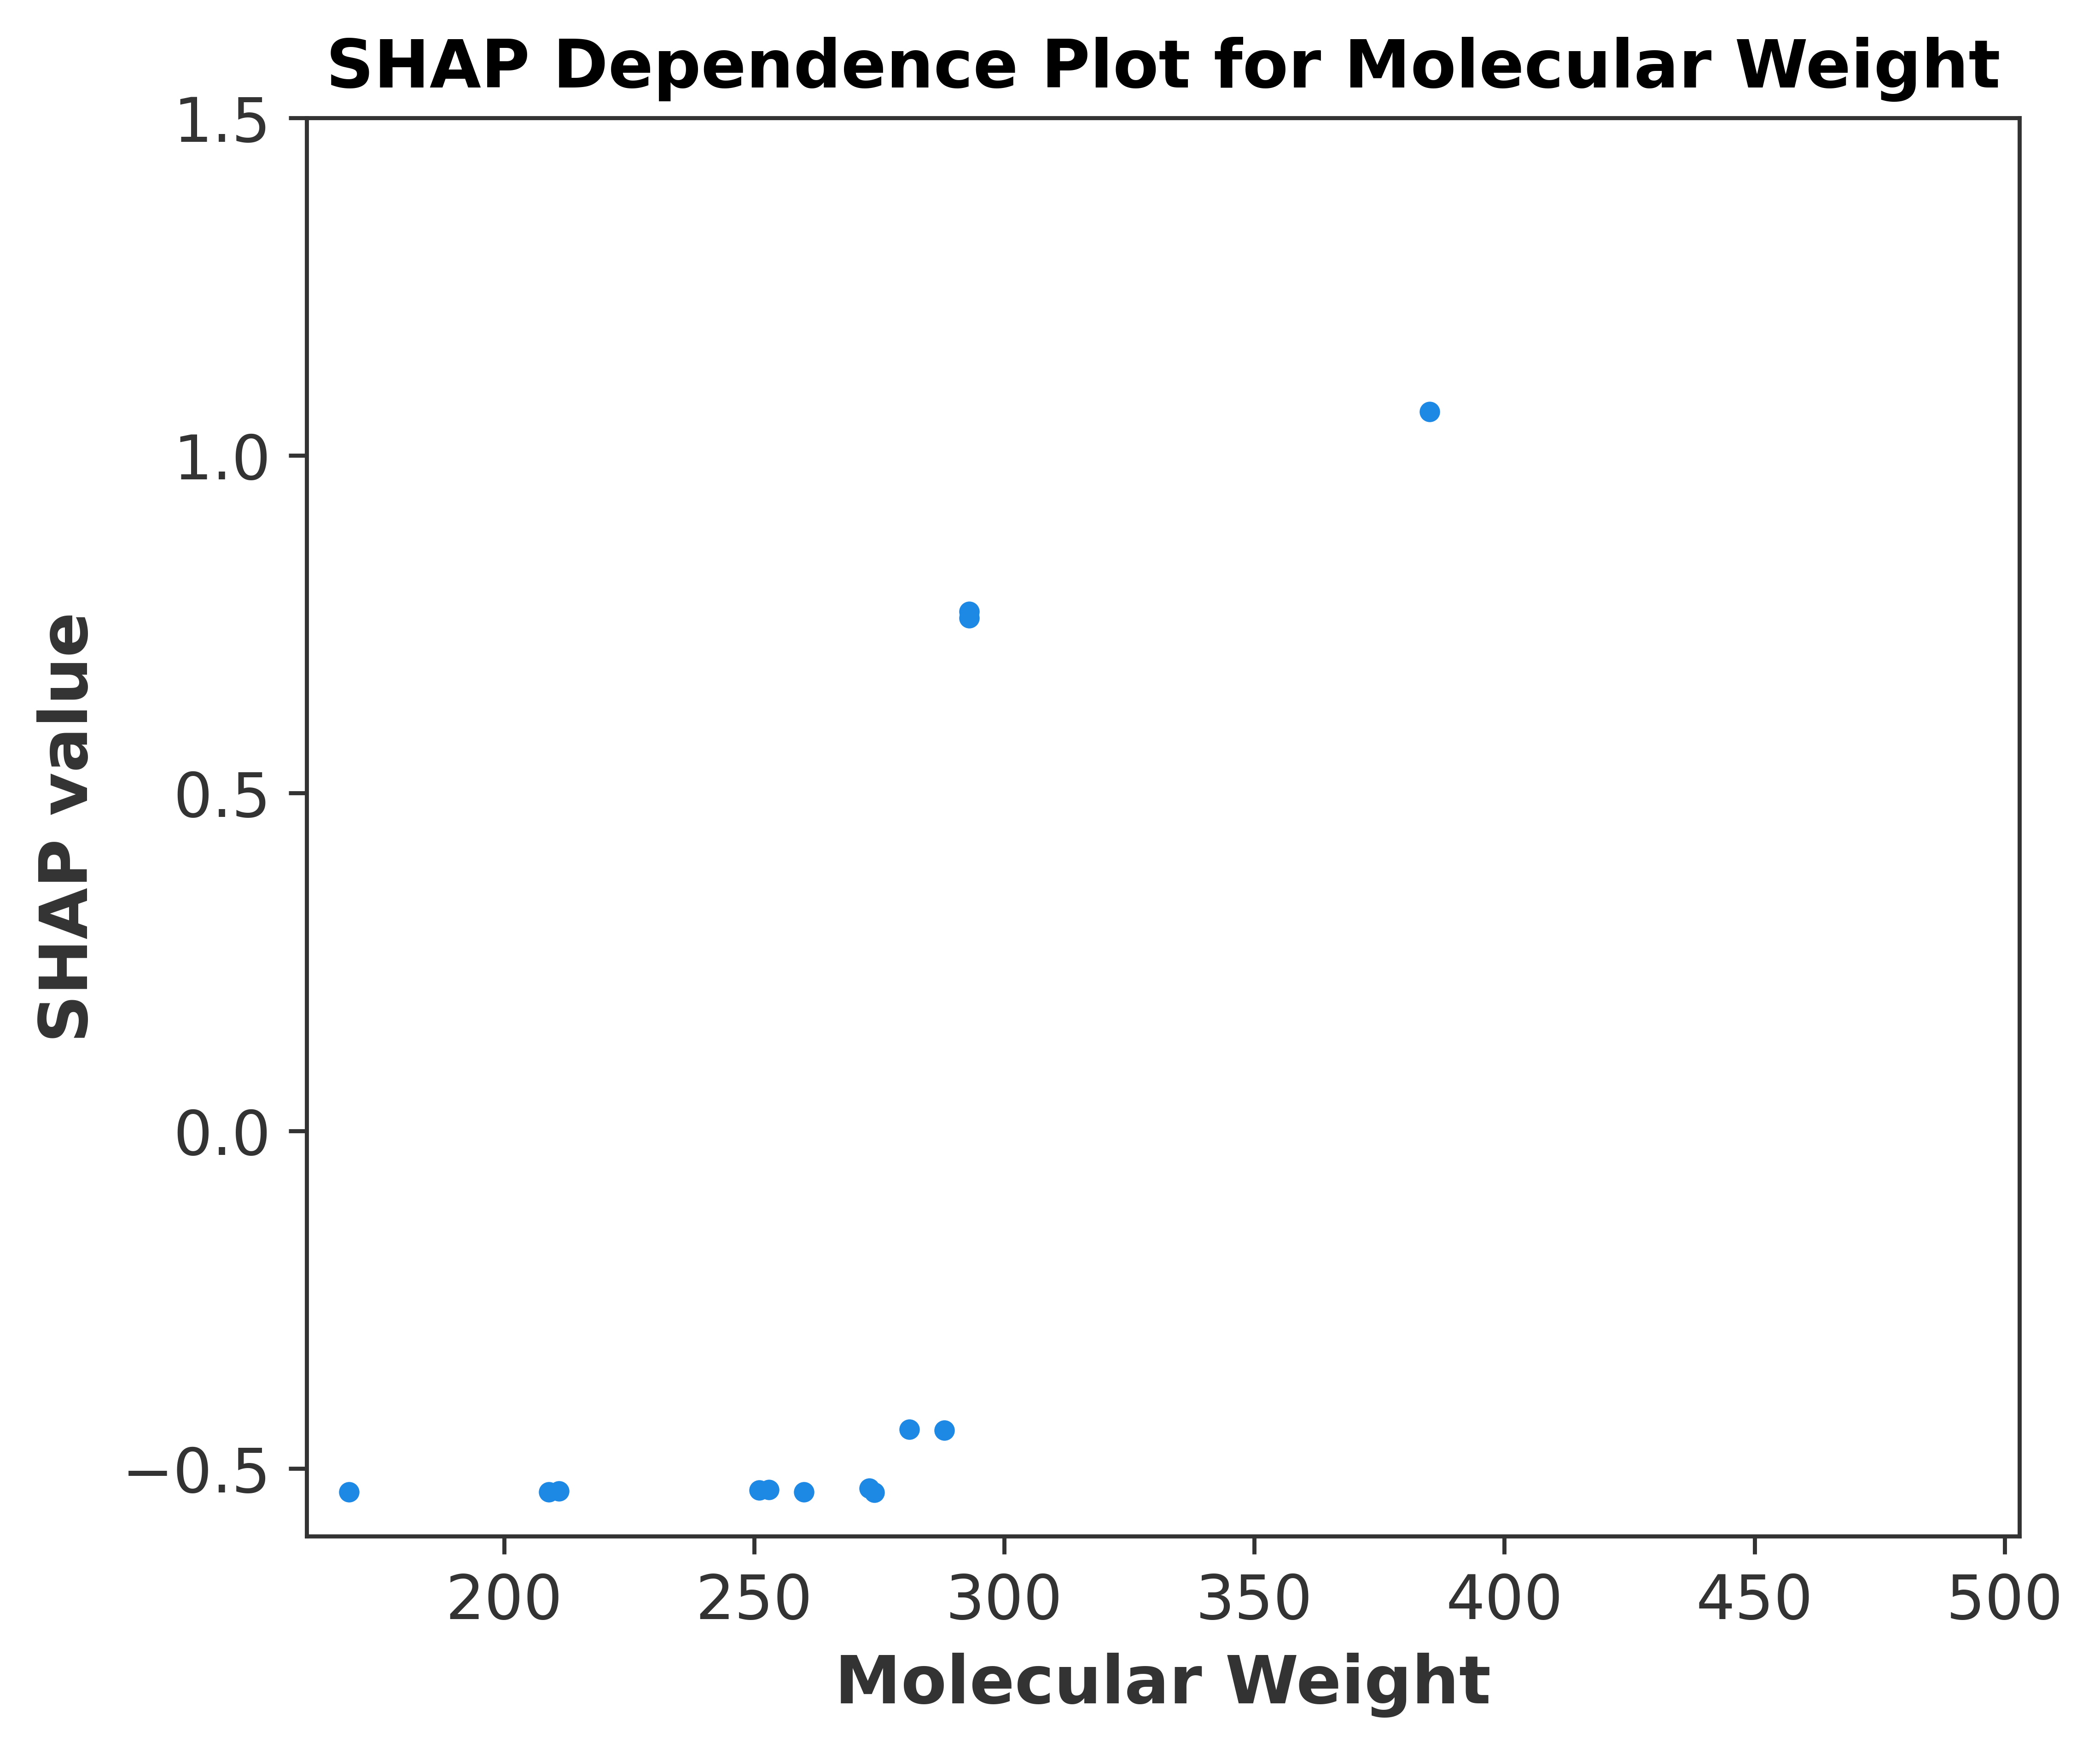

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Filter SHAP values and data for top 3 features
shap_values_combined_top3 = shap_values_combined[:, top_3_indices]
X_combined_df_top3 = X_combined_df.iloc[:, top_3_indices]

# Set up Matplotlib font properties
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 800

# Generate SHAP dependence plots for each of the top 3 features with square plots
for feature in top_3_features:
    plt.figure(figsize=(8, 8))  # Set square figure size (8x8 inches)

    # Create the SHAP dependence plot
    shap.dependence_plot(
        feature,
        shap_values_combined,
        X_combined_df,
        interaction_index=None,
        show=False
    )

    # Get current axes object
    ax = plt.gca()

    # Customize the spines to add axes on top and right
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set the aspect ratio to be square
    ax.set_aspect('auto')

    # Set y-ticks to range from -0.5 to 1.5
    plt.yticks(np.arange(-1.0, 1.6, 0.5), fontsize=12, fontweight='normal')

    # Set x-ticks and remove bold font weight
    plt.xticks(fontsize=12, fontweight='normal')

    plt.title(f"SHAP Dependence Plot for {feature}", fontsize=13, fontweight='bold')
    plt.xlabel(feature, fontsize=13, fontweight='bold')
    plt.ylabel("SHAP value", fontsize=13, fontweight='bold')

    # Adjust x and y limits to ensure proper spacing
    plt.xlim(X_combined_df[feature].min() - 0.05 * np.abs(X_combined_df[feature].min()),
             X_combined_df[feature].max() + 0.05 * np.abs(X_combined_df[feature].max()))
    plt.ylim(-0.6, 1.5)

    plt.show()


<Figure size 6400x6400 with 0 Axes>

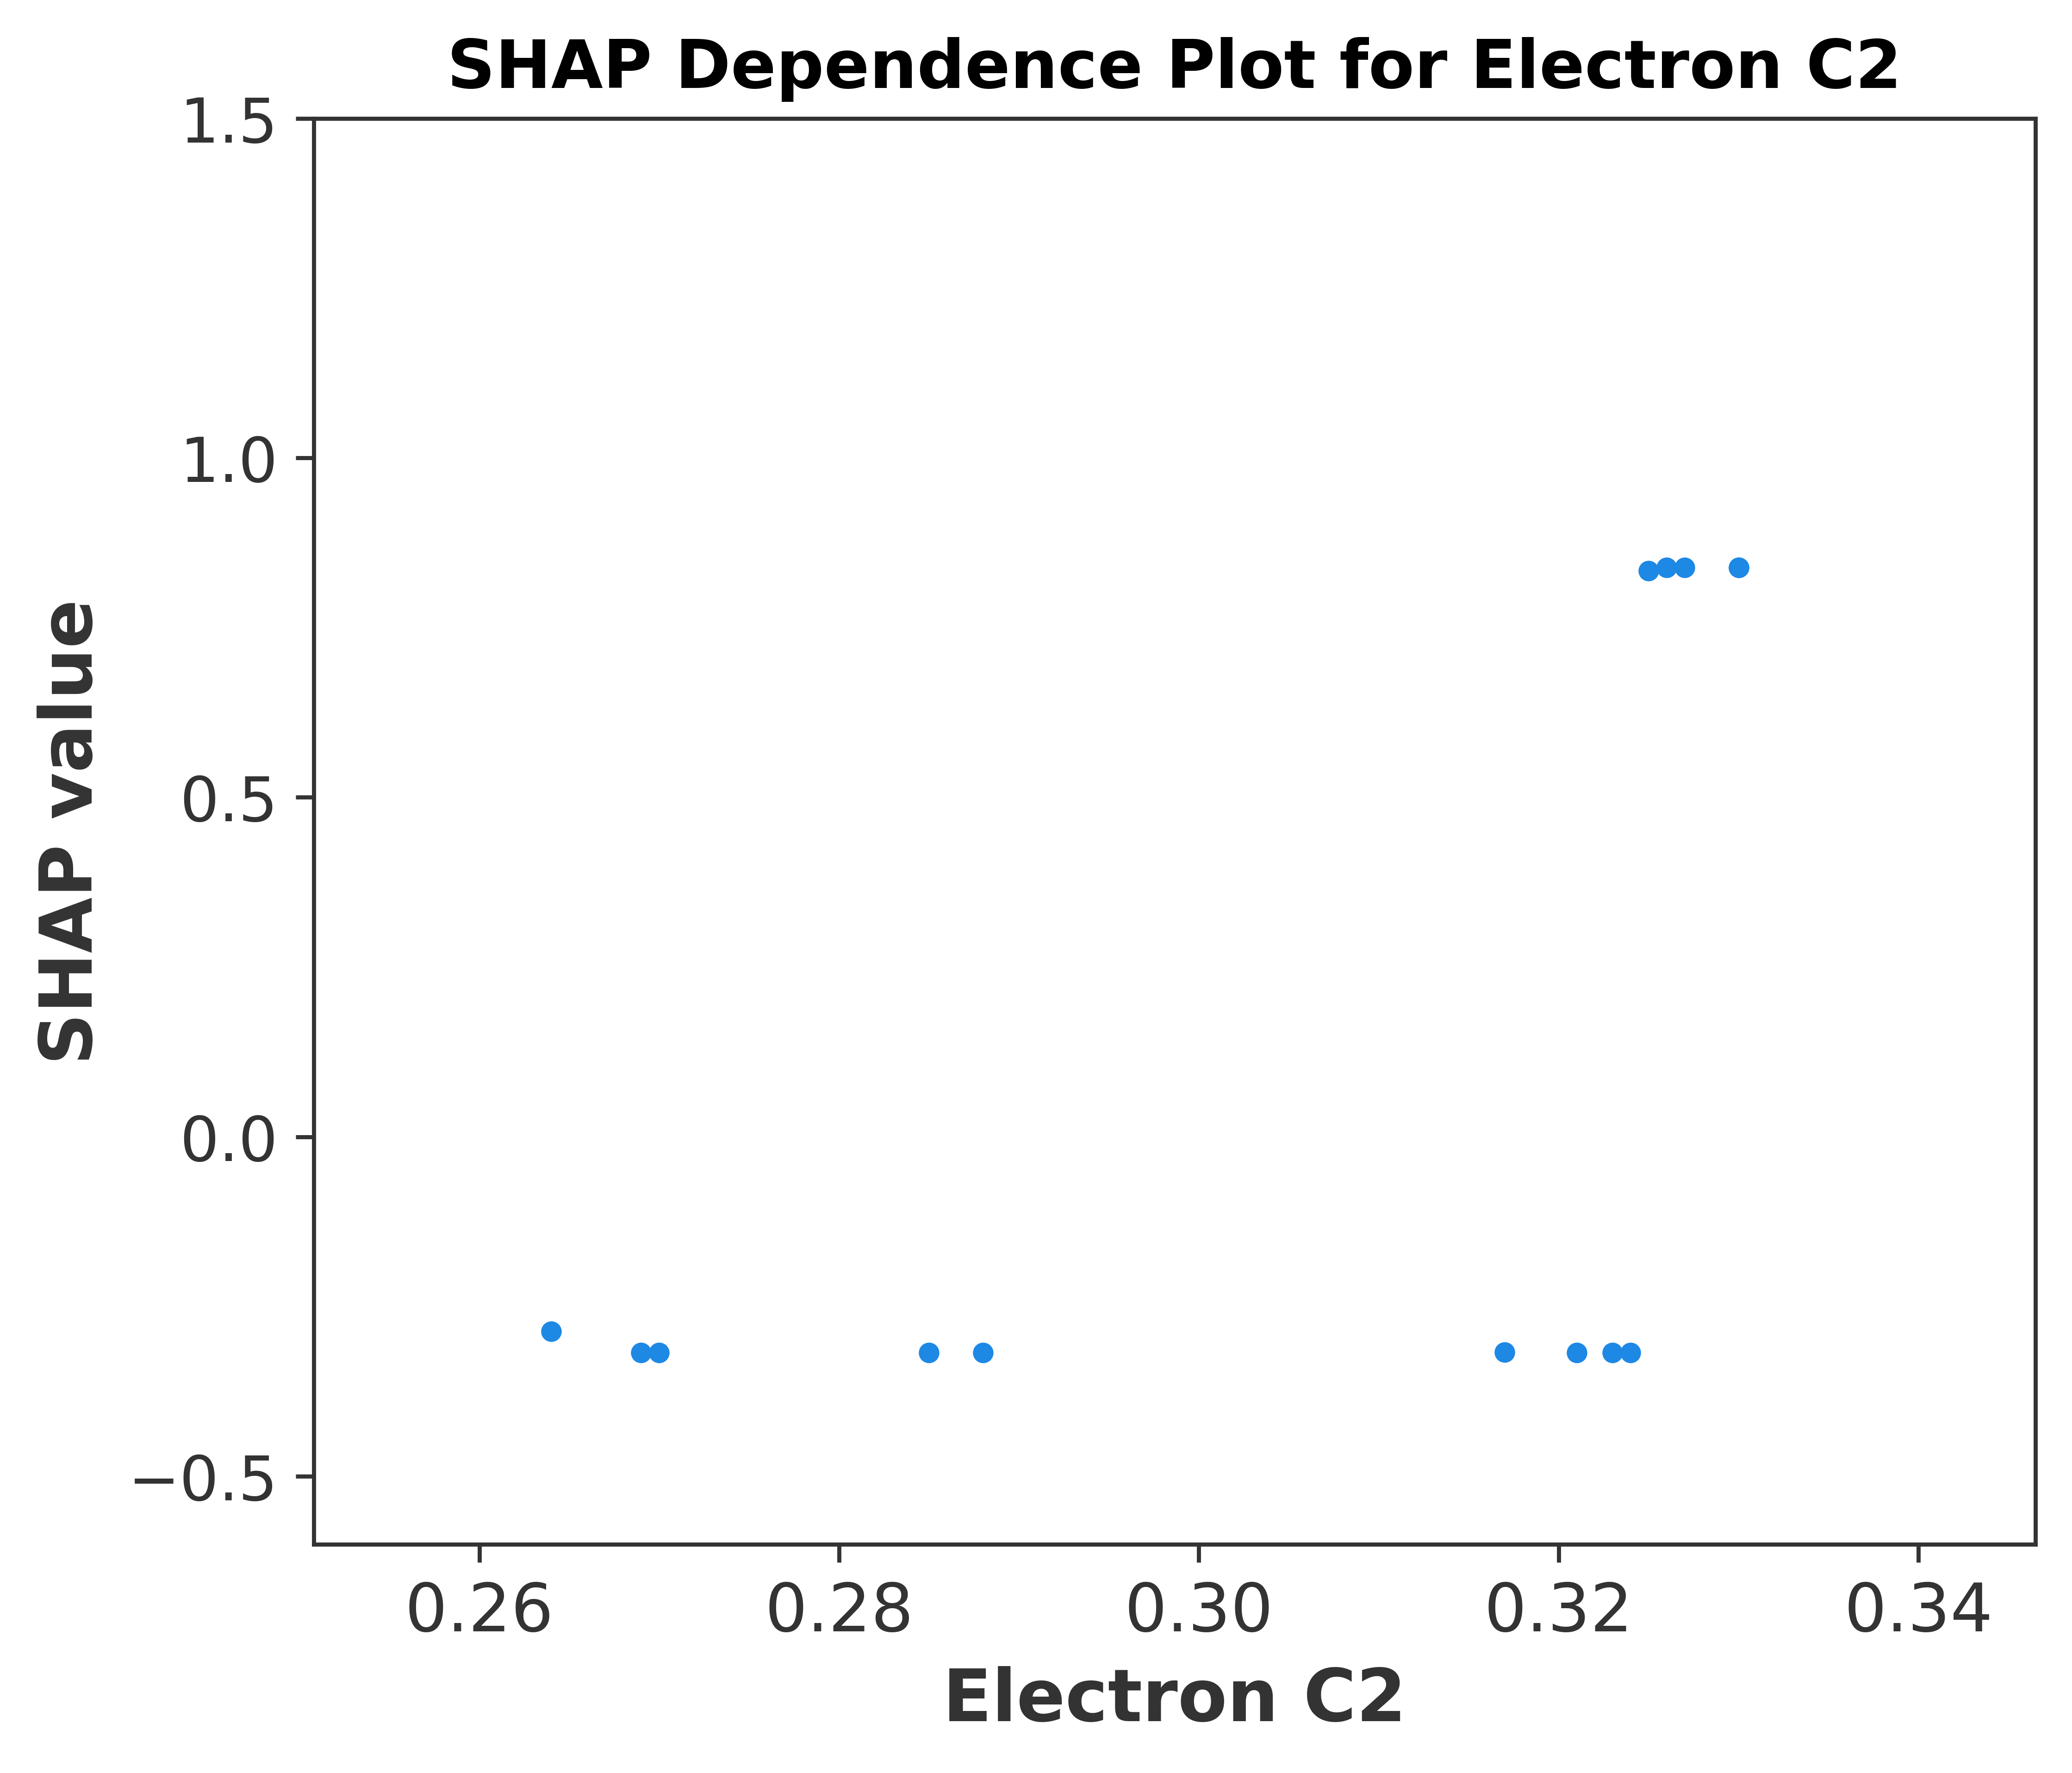

<Figure size 6400x6400 with 0 Axes>

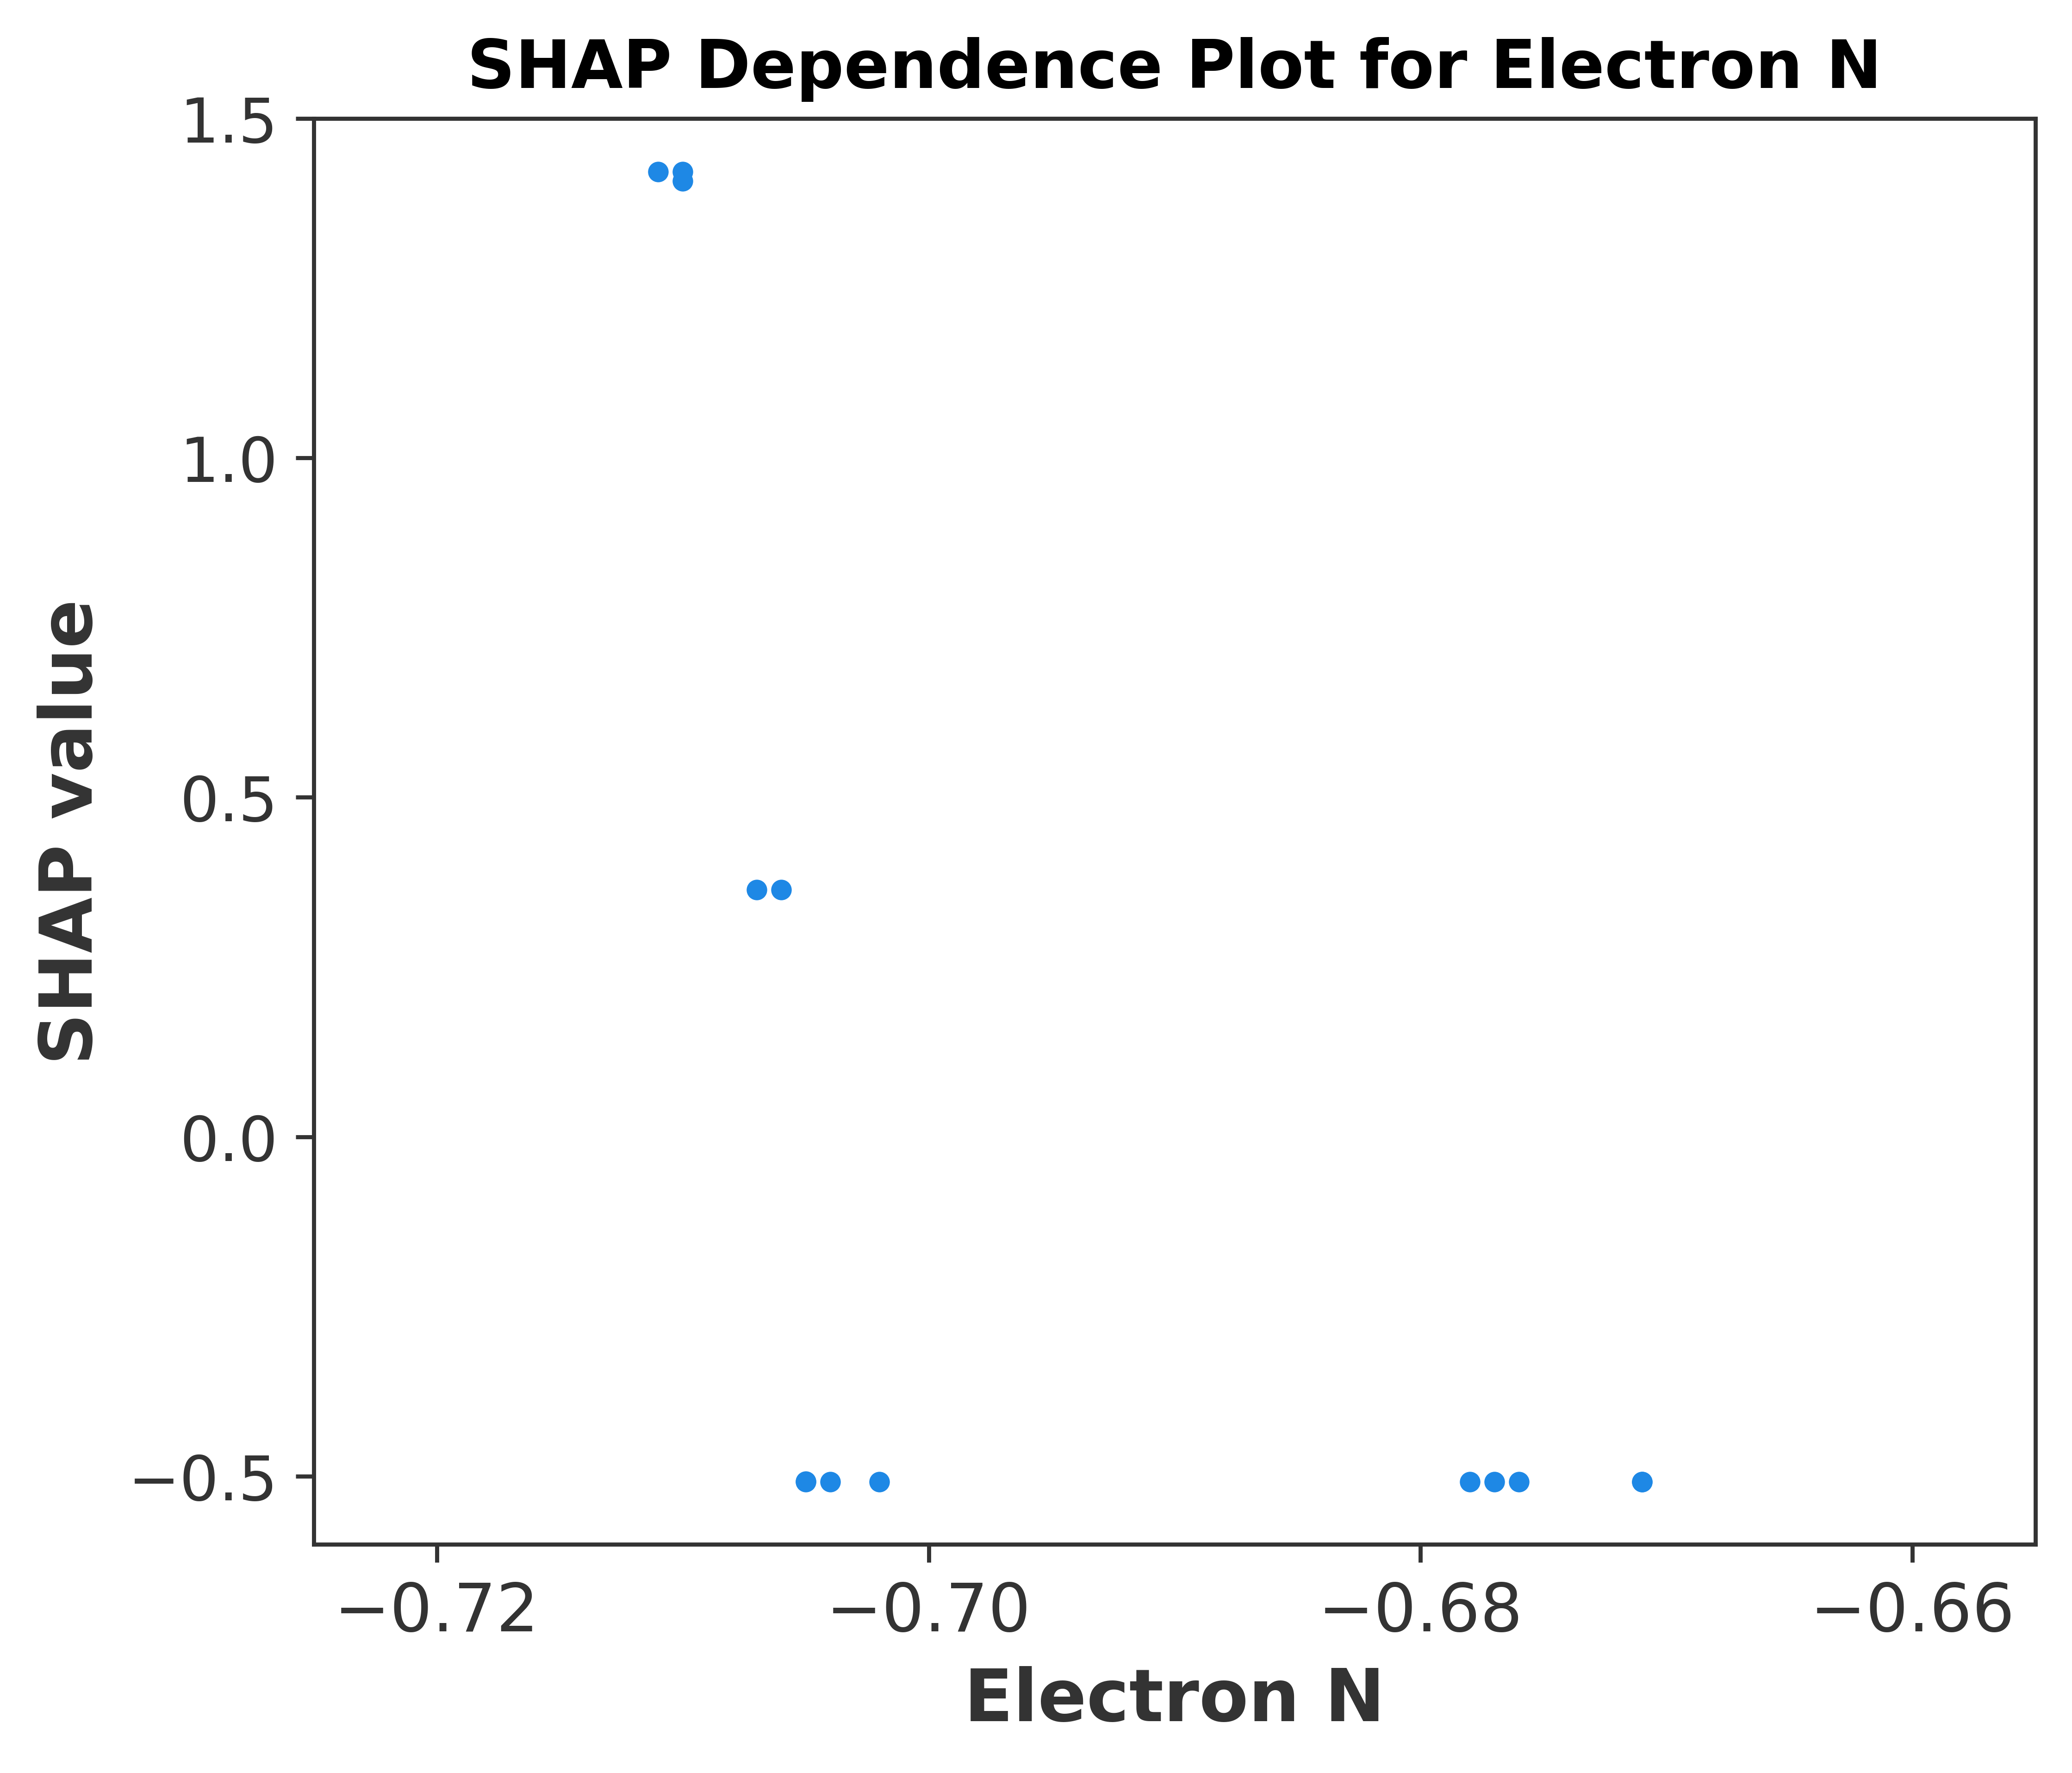

<Figure size 6400x6400 with 0 Axes>

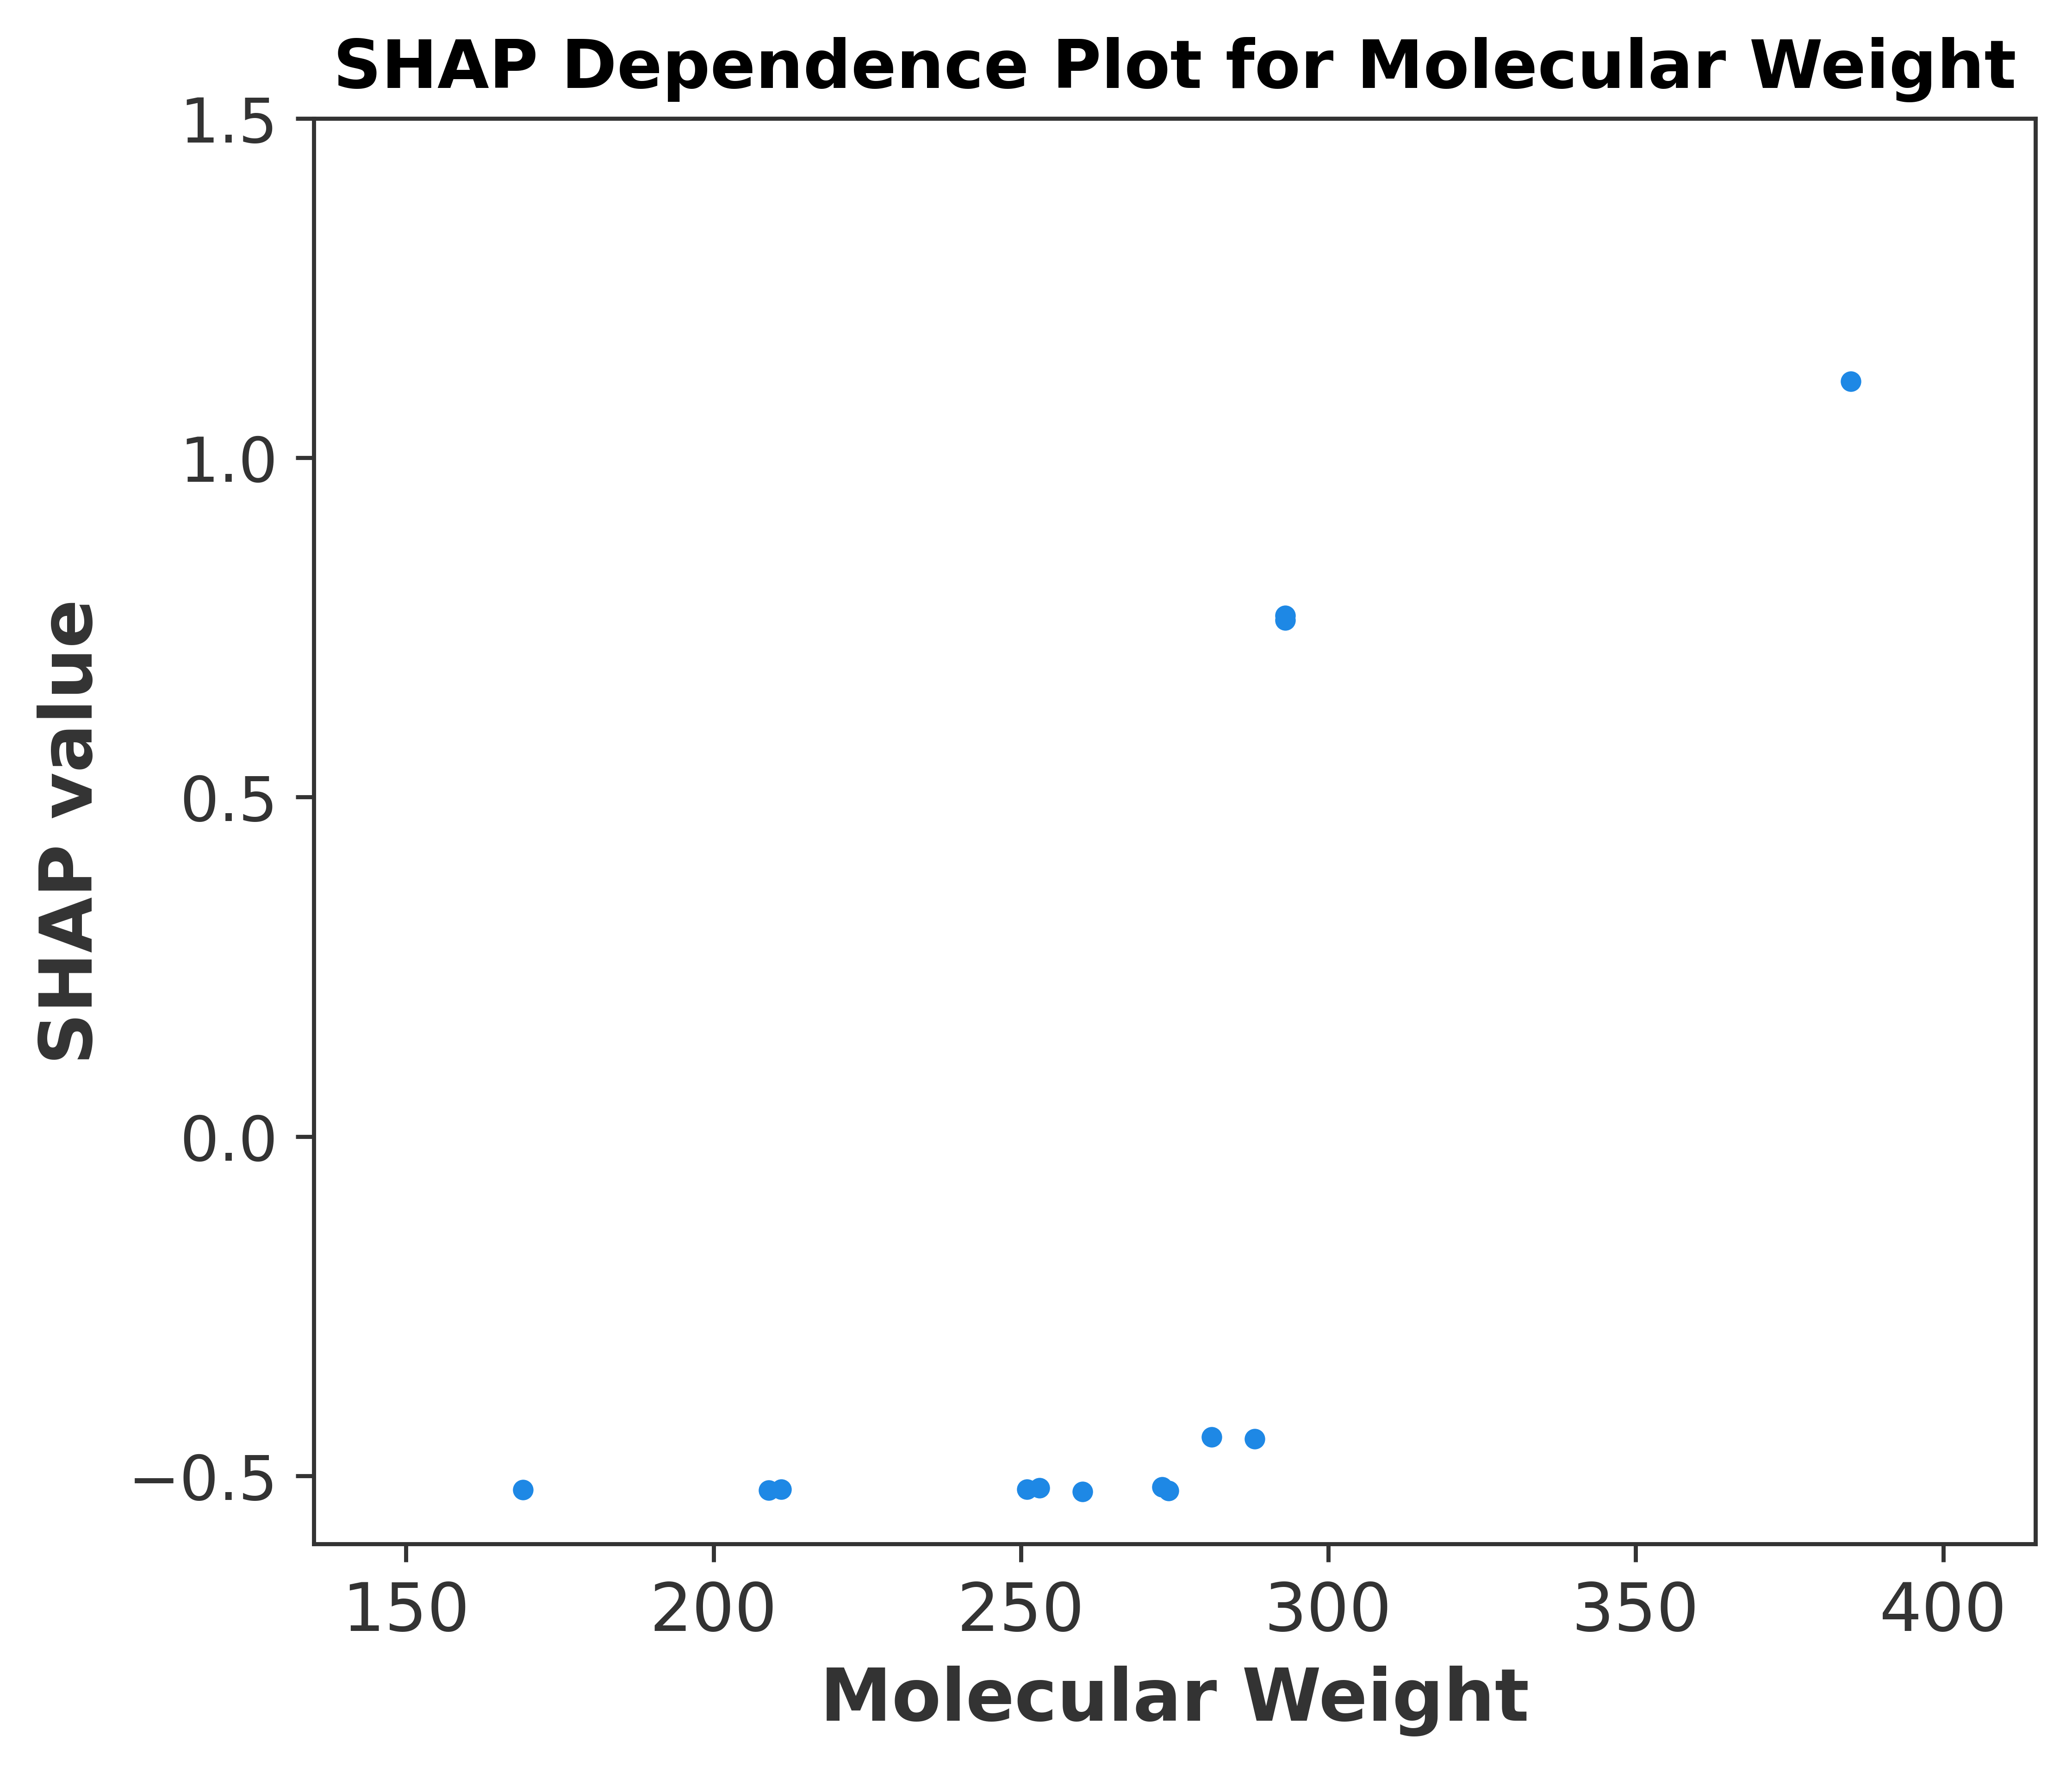

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Filter SHAP values and data for top 3 features
shap_values_combined_top3 = shap_values_combined[:, top_3_indices]
X_combined_df_top3 = X_combined_df.iloc[:, top_3_indices]

# Set up Matplotlib font properties
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 800

# Generate SHAP dependence plots for each of the top 3 features with square plots
for feature in top_3_features:
    plt.figure(figsize=(8, 8))  # Set square figure size (8x8 inches)

    # Create the SHAP dependence plot
    shap.dependence_plot(
        feature,
        shap_values_combined,
        X_combined_df,
        interaction_index=None,
        show=False
    )

    # Get current axes object
    ax = plt.gca()

    # Customize the spines to add axes on top and right
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set the aspect ratio to be square
    ax.set_aspect('auto')

    # Customize x-ticks and limits based on the feature
    if feature == 'Molecular Weight':
        plt.xticks(np.arange(0, 451, 50), fontsize=13, fontweight='normal')
        plt.xlim(135, 415)
    elif feature == 'Electron N':
        plt.xticks(np.arange(-0.72, -0.65, 0.02), fontsize=13, fontweight='normal')
        plt.xlim(-0.725, -0.655)
    else:
        plt.xticks(fontsize=13, fontweight='normal')
        plt.xlim(X_combined_df[feature].min() - 0.05 * np.abs(X_combined_df[feature].min()),
                 X_combined_df[feature].max() + 0.05 * np.abs(X_combined_df[feature].max()))

    # Set y-ticks to range from -0.5 to 1.5
    plt.yticks(np.arange(-1.0, 1.6, 0.5), fontsize=12, fontweight='normal')

    plt.title(f"SHAP Dependence Plot for {feature}", fontsize=13, fontweight='bold')
    plt.xlabel(feature, fontsize=14, fontweight='bold')
    plt.ylabel("SHAP value", fontsize=14, fontweight='bold')

    # Adjust y-limits to ensure proper spacing
    plt.ylim(-0.6, 1.5)

    plt.show()
